## OCHRE User Tutorial

* [Set up](#setup)
  * [Installation](#install)
  * [Getting input files](#inputs)
* [Running a basic house model](#dwelling)
* [Running a single equipment model](#equipment)
* [Running with external controllers](#control)
  * [Time-based HVAC setpoint control](#hvac-control)
  * [Occupancy-based setpoint control](#occupancy-control)

This tutorial can be found online [here](https://github.nrel.gov/Customer-Modeling/ochre/blob/dev/notebook/user_tutorial.ipynb).

Note that this tutorial only covers use cases with a single building or single piece of equipment.
OCHRE can be used to simulate a community or fleet of devices, both in parallel simulations or in co-simulation.


### <a name="setup"></a>Set up


#### <a name="install"></a>Installation

OCHRE can be installed using `pip` from the command line:

```
pip install git+https://github.nrel.gov/Customer-Modeling/ochre.git@dev
```

We currently recommend using the `dev` branch.

Note that OCHRE requires Python version 3.9 or higher.


#### <a name="inputs"></a>Getting input files

OCHRE Dwelling models require 3 inputs files:
* An HPXML file with building properties (xml)
* An occupancy schedule file (csv)
* A weather file (epw, or csv with NSRDB format)

We recommend using [ResStock](https://www.nrel.gov/buildings/resstock.html) (version 3.0+) or
[BEopt](https://www.nrel.gov/buildings/beopt.html) (version 3.0+) to create HPXML and occupancy schedule files.
OCHRE has sample files [here](https://github.nrel.gov/Customer-Modeling/ochre/tree/dev/defaults/Input%20Files).

Weather files can be downloaded from [NSRDB](https://nsrdb.nrel.gov/),
[BEopt](https://www.nrel.gov/buildings/beopt.html),
or from ResStock's [dataset](https://data.nrel.gov/submissions/156).


### <a name="dwelling"></a>Running a basic house model

For more details, see [bin/run_dwelling.py](https://github.nrel.gov/Customer-Modeling/ochre/blob/main/bin/run_dwelling.py)

In [19]:
import os
import datetime as dt
import pandas as pd

from ochre import Dwelling
from ochre.FileIO import default_input_path

simulation_name = 'Sample House'

dwelling_args = {
    # Timing parameters
    'start_time': dt.datetime(2018, 1, 1, 0, 0),  # year, month, day, hour, minute
    'time_res': dt.timedelta(minutes=10),         # time resolution of the simulation
    'duration': dt.timedelta(days=3),             # duration of the simulation

    # Input files
    'properties_file': os.path.join(default_input_path, 'Input Files', 'sample_resstock_properties.xml'),
    'schedule_input_file': os.path.join(default_input_path, 'Input Files', 'sample_resstock_schedule.csv'),
    'weather_file': os.path.join(default_input_path, 'Weather', 'USA_CO_Denver.Intl.AP.725650_TMY3.epw'),

    # Output parameters
    'verbosity': 4,                         # verbosity of time series files (0-9)
    'output_path': os.getcwd(),             # defaults to properties_file path

    # Equipment parameters (see bin/run_dwelling.py for more options)
    # 'Equipment': {
    #     'PV': {
    #         'capacity': 5,   # in kW
    #         'tilt': 20,      # in degrees
    #         'azimuth': 180,  # in degrees
    #     }
    # },
}

# Create Dwelling model
dwelling = Dwelling(name=simulation_name, **dwelling_args)


2023-02-21 13:48:33.050735 - Sample House at 2018-01-01 00:00:00: Initializing OCHRE simulation (v0.7.5)
2023-02-21 13:48:33.050735 - Sample House at 2018-01-01 00:00:00: Removing previous results
2023-02-21 13:48:33.563566 - Sample House at 2018-01-01 00:00:00: Dwelling Initialized


In [20]:
# Run OCHRE simulation (returns DataFrames of timeseries results and a dictionary of metrics)
df_baseline, metrics, hourly = dwelling.simulate()

# Load results from previous run
# output_path = dwelling_args.get('output_path', os.path.dirname(dwelling_args['properties_file']))
# df, metrics, hourly = Analysis.load_ochre(output_path, simulation_name)

df_baseline.head()


2023-02-21 13:48:35.049988 - Sample House at 2018-01-01 00:00:00: Running Simulation for 3 days, 0:00:00
2023-02-21 13:48:36.040902 - Sample House at 2018-01-04 00:00:00: Simulation complete, time series results saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House.csv
2023-02-21 13:48:36.049250 - Sample House at 2018-01-04 00:00:00: Post-processing metrics saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House_metrics.csv
2023-02-21 13:48:36.067329 - Sample House at 2018-01-04 00:00:00: Hourly results saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House_hourly.csv


,Total Electric Power (kW),Total Reactive Power (kVAR),Total Gas Power (therms/hour),Total Electric Energy (kWh),Total Reactive Energy (kVARh),Total Gas Energy (therms),HVAC Heating Electric Power (kW),HVAC Cooling Electric Power (kW),Water Heating Electric Power (kW),Other Electric Power (kW),...,Net Sensible Heat Gain - Garage (W),Net Sensible Heat Gain - Attic (W),Window Transmitted Solar Gain (W),HVAC Heating Delivered (kW),HVAC Cooling Delivered (kW),Water Heating Delivered (kW),Hot Water Delivered (L/min),Hot Water Outlet Temperature (C),Hot Water Delivered (kW),"Hot Water Unmet Demand, Showers (kW)"
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,20.701125,12.618629,0.0,3.450187,2.103105,0.0,18.810878,0.05,1.108221,0.732025,...,-6944.332322,-934.647156,0.0,18.812897,0.0,1.108221,0.143690,51.111111,0.411409,0.0
2018-01-01 00:10:00,14.790308,9.226331,0.0,2.465051,1.537722,0.0,13.559123,0.05,0.449159,0.732025,...,-4709.425896,-852.849665,0.0,15.029046,0.0,0.449159,0.141773,51.666411,0.411409,0.0
2018-01-01 00:20:00,14.678509,9.154324,0.0,2.446418,1.525721,0.0,13.447646,0.05,0.448837,0.732025,...,-3456.879458,-828.321415,0.0,14.948707,0.0,0.448837,0.141772,51.666703,0.411409,0.0
2018-01-01 00:30:00,14.633605,9.125319,0.0,2.438934,1.520887,0.0,13.402743,0.05,0.448837,0.732025,...,-2745.050484,-799.747595,0.0,14.916346,0.0,0.448837,0.141772,51.666703,0.411409,0.0
2018-01-01 00:40:00,14.617040,9.114619,0.0,2.436173,1.519103,0.0,13.386178,0.05,0.448837,0.732025,...,-2334.923464,-768.595538,0.0,14.904408,0.0,0.448837,0.141772,51.666703,0.411409,0.0


In [21]:
metrics

{'Total Electric Energy (kWh)': 491.93514979172005,
 'Total Gas Energy (therms)': 0.0,
 'HVAC Heating Electric Energy (kWh)': 309.8137302463968,
 'HVAC Cooling Electric Energy (kWh)': 3.6,
 'Water Heating Electric Energy (kWh)': 70.5491814723713,
 'Other Electric Energy (kWh)': 107.9722380729519,
 'Other Gas Energy (therms)': 0.0,
 'Average Temperature - Indoor (C)': 19.812190181073767,
 'Average Temperature - Foundation (C)': 5.833145422714986,
 'Average Temperature - Garage (C)': -1.755225650394317,
 'Average Temperature - Attic (C)': -0.9980051699739894,
 'Unmet Heating Load (C-hours)': 0.0,
 'Unmet Cooling Load (C-hours)': 0.0,
 'Total HVAC Heating Delivered (kWh)': 420.14570511391685,
 'Total HVAC Cooling Delivered (kWh)': 0.0,
 'Total Water Heating Delivered (kWh)': 70.5491814723713,
 'Total Hot Water Unmet Demand, Showers (kWh)': 0.0,
 'Total Hot Water Delivered (gal/day)': 123.20057505484492,
 'Total Hot Water Delivered (kWh)': 67.77357356633911,
 'Dishwasher Cycles': 3,
 'Cook

Using matplotlib backend: TkAgg


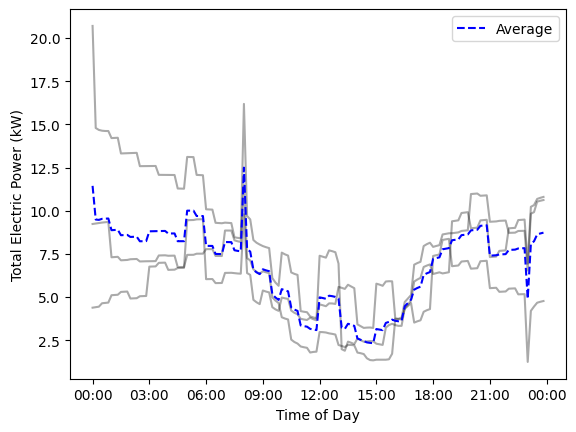

In [22]:
%matplotlib

from ochre import CreateFigures

# Plot results
CreateFigures.plot_power_stack(df_baseline)
CreateFigures.plot_daily_profile(df_baseline, 'Total Electric Power (kW)', plot_max=False, plot_min=False)

### <a name="equipment"></a>Running a single equipment model

For more details and examples, see
[bin/run_equipment.py](https://github.nrel.gov/Customer-Modeling/ochre/blob/main/bin/run_equipment.py)

In [8]:
import numpy as np

from ochre import ElectricResistanceWaterHeater

water_heater_args = {
    'start_time': dt.datetime(2018, 1, 1, 0, 0),  # year, month, day, hour, minute
    'time_res': dt.timedelta(minutes=1),
    'duration': dt.timedelta(days=10),
    'verbosity': 6,  # verbosity of results (1-9)
    'save_results': False,  # will not save results to a file
    
    # Equipment parameters
    'Initial Temperature (C)': 49,
    'Setpoint Temperature (C)': 51,
    'Deadband Temperature (C)': 5,
    'Capacity (W)': 4800,
    'Efficiency (-)': 1,
    'Tank Volume (L)': 250,
    'Tank Height (m)': 1.22,
    'UA (W/K)': 2.17,

    'schedule': None,  # defined below
}

# create example water draw schedule and add to equipment args
times = pd.date_range(water_heater_args['start_time'], water_heater_args['start_time'] + water_heater_args['duration'], 
                      freq=water_heater_args['time_res'])
water_draw_magnitude = 12  # L/min
hot_water_draws = np.random.choice([0, water_draw_magnitude], p=[0.99, 0.01], size=len(times))
water_heater_args['schedule'] = pd.DataFrame({
    'Showers (L/min)': hot_water_draws,
    'Zone Temperature (C)': 20,
    'Mains Temperature (C)': 7,
}, index=times)

# Initialize equipment
water_heater = ElectricResistanceWaterHeater(**water_heater_args)

2023-02-21 13:39:01.311174 - Water Tank at 2018-01-01 00:00:00: Initializing OCHRE simulation (v0.7.5)
2023-02-21 13:39:01.351175 - Electric Resistance Water Heater at 2018-01-01 00:00:00: Initializing OCHRE simulation (v0.7.5)


In [9]:
# Run simulation
df = water_heater.simulate()

# Show results
df.head()


2023-02-21 13:39:05.952054 - Electric Resistance Water Heater at 2018-01-01 00:00:00: Running Simulation for 10 days, 0:00:00
2023-02-21 13:39:06.629532 - Electric Resistance Water Heater at 2018-01-11 00:00:00: Simulation complete, time series results saved in memory (not to a file)
2023-02-21 13:39:06.629532 - Water Tank at 2018-01-01 00:00:00: Simulation complete, no results


,Water Heating Electric Power (kW),Water Heating Reactive Power (kVAR),Water Heating Mode,Water Heating Delivered (kW),Water Heating COP (-),Water Heating Sensible Heat to Air (kW),Water Heating Deadband Upper Limit (C),Water Heating Deadband Lower Limit (C),Hot Water Delivered (L/min),Hot Water Outlet Temperature (C),Hot Water Delivered (kW),"Hot Water Unmet Demand, Showers (kW)",Hot Water Heat Injected (kW),Hot Water Heat Loss (kW),Hot Water Average Temperature (C),Hot Water Maximum Temperature (C),Hot Water Minimum Temperature (C),Hot Water Mains Temperature (C)
Time,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0,Off,0.0,0.0,0.062926,51,46,0.0,49.000000,0.0,0.0,0.0,0.062926,49.000000,49.000000,49.000000,7
2018-01-01 00:01:00,0.0,0,Off,0.0,0.0,0.062918,51,46,0.0,48.996077,0.0,0.0,0.0,0.062918,48.996390,48.996546,48.996077,7
2018-01-01 00:02:00,0.0,0,Off,0.0,0.0,0.062910,51,46,0.0,48.992155,0.0,0.0,0.0,0.062910,48.992780,48.993092,48.992155,7
2018-01-01 00:03:00,0.0,0,Off,0.0,0.0,0.062902,51,46,0.0,48.988233,0.0,0.0,0.0,0.062902,48.989170,48.989639,48.988233,7
2018-01-01 00:04:00,0.0,0,Off,0.0,0.0,0.062895,51,46,0.0,48.984312,0.0,0.0,0.0,0.062895,48.985561,48.986186,48.984312,7


In [11]:
CreateFigures.plot_daily_profile(df, 'Water Heating Electric Power (kW)', plot_max=False, plot_min=False)
CreateFigures.plot_time_series_detailed((df['Hot Water Outlet Temperature (C)'],))


(<Figure size 640x480 with 1 Axes>, (<AxesSubplot:>, None))

### <a name="control"></a>Running with external controllers

For more details and examples, see
[bin/run_external_control.py](https://github.nrel.gov/Customer-Modeling/ochre/blob/main/bin/run_external_control.py)

#### <a name="hvac-control"></a>Time-based HVAC setpoint control

This control will reduce the heating setpoint by 1C from 5-9PM each day.

We use the same house model as above.

In [23]:
# Option 1: Adjust setpoints in the schedule, then run the simulation

# Create Dwelling model (same as above)
dwelling = Dwelling(name=simulation_name, **dwelling_args)

# Get HVAC heater setpoints
heater = dwelling.get_equipment_by_end_use('HVAC Heating')
setpoints = heater.schedule['Heating Setpoint (C)']

# Reduce heating setpoint by 1C from 5-9PM
peak_times = setpoints.between_time(dt.time(17, 0, 0), dt.time(21, 0, 0), inclusive='left').index
setpoints.loc[peak_times] -= 1
heater.reset_time()  # resets the schedule

# Run simulation
df, hourly, metrics = dwelling.simulate()

# Plot HVAC power and indoor temperature for baseline and control cases
data = {'Baseline': df_baseline,
        'Control': df}
plot_info = [('HVAC Heating Electric Power (kW)', 'Heating Power', 'r'),
             ('Temperature - Indoor (C)', 'Indoor Temperature', 'k', False)]
fig, (ax1, ax2) = CreateFigures.multi_comparison_plot(data, plot_info)
ax1.set_ylabel('Power (kW)')
ax2.set_ylabel('Temperature (C)')


2023-02-21 13:48:47.907551 - Sample House at 2018-01-01 00:00:00: Initializing OCHRE simulation (v0.7.5)
2023-02-21 13:48:47.907551 - Sample House at 2018-01-01 00:00:00: Removing previous results
2023-02-21 13:48:48.565094 - Sample House at 2018-01-01 00:00:00: Dwelling Initialized
2023-02-21 13:48:48.573687 - Sample House at 2018-01-01 00:00:00: Running Simulation for 3 days, 0:00:00
2023-02-21 13:48:49.495488 - Sample House at 2018-01-04 00:00:00: Simulation complete, time series results saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House.csv
2023-02-21 13:48:49.504493 - Sample House at 2018-01-04 00:00:00: Post-processing metrics saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House_metrics.csv
2023-02-21 13:48:49.524865 - Sample House at 2018-01-04 00:00:00: Hourly results saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House_hourly.csv


Text(0, 0.5, 'Temperature (C)')

In [25]:
# Option 2: Adjust setpoints within the simulation

# Create Dwelling model
dwelling = Dwelling(name=simulation_name, **dwelling_args)

# Get HVAC heater and initial setpoint
heater = dwelling.get_equipment_by_end_use('HVAC Heating')

# Run OCHRE simulation in for loop
for t in dwelling.sim_times:
    assert dwelling.current_time == t

    # Get HVAC heating setpoint, reduce by 1C from 5-9PM
    setpoint = heater.schedule.loc[t, 'Heating Setpoint (C)']  # Original setpoint for current time
    if 17 <= t.hour <= 21:
        setpoint -= 1

    # Set the external control signal
    control_signal = {
        'HVAC Heating': {
            'Setpoint': setpoint,
        }
    }

    # Send the control signal to OCHRE and run for 1 time step
    house_status = dwelling.update(control_signal=control_signal)

# End the simulation
df, hourly, metrics = dwelling.finalize()

# Plot HVAC power and indoor temperature for baseline and control cases
data = {'Baseline': df_baseline,
        'Control': df}
plot_info = [('HVAC Heating Electric Power (kW)', 'Heating Power', 'r'),
             ('Temperature - Indoor (C)', 'Indoor Temperature', 'k', False)]
fig, (ax1, ax2) = CreateFigures.multi_comparison_plot(data, plot_info)
ax1.set_ylabel('Power (kW)')
ax2.set_ylabel('Temperature (C)')


2023-02-21 13:50:30.391314 - Sample House at 2018-01-01 00:00:00: Initializing OCHRE simulation (v0.7.5)
2023-02-21 13:50:30.392315 - Sample House at 2018-01-01 00:00:00: Removing previous results
2023-02-21 13:50:31.074724 - Sample House at 2018-01-01 00:00:00: Dwelling Initialized
2023-02-21 13:50:32.103990 - Sample House at 2018-01-04 00:00:00: Simulation complete, time series results saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House.csv
2023-02-21 13:50:32.114056 - Sample House at 2018-01-04 00:00:00: Post-processing metrics saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House_metrics.csv
2023-02-21 13:50:32.139317 - Sample House at 2018-01-04 00:00:00: Hourly results saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House_hourly.csv


Text(0, 0.5, 'Temperature (C)')

#### <a name="occupancy-control"></a>Occupancy-based setpoint control

This control will reduce the heating setpoint by 1C if the house is unoccupied.

We use the same house model as above.

In [26]:
# Create Dwelling model
dwelling = Dwelling(name=simulation_name, **dwelling_args)

# Get HVAC heater and initial setpoint
heater = dwelling.get_equipment_by_end_use('HVAC Heating')
setpoint = heater.schedule.loc[dwelling.start_time, 'Heating Setpoint (C)']
occupied = True

# Run OCHRE simulation in for loop
for t in dwelling.sim_times:
    assert dwelling.current_time == t

    # Get HVAC heating setpoint and reduce by 1C if the house is unoccupied
    setpoint = heater.schedule.loc[t, 'Heating Setpoint (C)']  # Original setpoint for current time
    if not occupied:
        setpoint -= 1

    # Set the external control signal
    control_signal = {
        'HVAC Heating': {
            'Setpoint': setpoint,
        }
    }

    # Send the control signal to OCHRE and run for 1 time step
    house_status = dwelling.update(control_signal=control_signal)

    # Update occupancy status
    occupied = house_status['Occupancy (Persons)'] > 0

# End the simulation
df, hourly, metrics = dwelling.finalize()

# Plot HVAC power and indoor temperature for baseline and control cases
data = {'Baseline': df_baseline,
        'Control': df}
plot_info = [('HVAC Heating Electric Power (kW)', 'Heating Power', 'r'),
             ('Temperature - Indoor (C)', 'Indoor Temperature', 'k', False),
             ('Occupancy (Persons)', 'Occupancy', 'b')]
fig, (ax1, ax2) = CreateFigures.multi_comparison_plot(data, plot_info)
ax1.set_ylabel('Power (kW) and Occupancy (Persons)')
ax2.set_ylabel('Temperature (C)')


2023-02-21 13:54:58.994826 - Sample House at 2018-01-01 00:00:00: Initializing OCHRE simulation (v0.7.5)
2023-02-21 13:54:58.995904 - Sample House at 2018-01-01 00:00:00: Removing previous results
2023-02-21 13:54:59.551984 - Sample House at 2018-01-01 00:00:00: Dwelling Initialized
2023-02-21 13:55:00.278807 - Sample House at 2018-01-04 00:00:00: Simulation complete, time series results saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House.csv
2023-02-21 13:55:00.291361 - Sample House at 2018-01-04 00:00:00: Post-processing metrics saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House_metrics.csv
2023-02-21 13:55:00.320220 - Sample House at 2018-01-04 00:00:00: Hourly results saved to: c:\Users\mblonsky\Github\ochre\notebook\Sample House_hourly.csv


(<Figure size 640x480 with 2 Axes>, (<AxesSubplot:>, <AxesSubplot:>))